In [2]:
import sys
sys.path.insert(0, '/Users/kedzie/Documents/Berkeley/notebooks/utilities')

import pdb
import pandas as pd
import numpy as np
import scipy
from scipy.optimize import curve_fit
from matplotlib import rcParams as rc
rc['mathtext.default'] = 'regular'
import matplotlib.pyplot as plt
from collections.abc import Iterable
from utility_functions.utils import *
rc['font.size'] = 14

In [101]:
def baselinecorr(data, mz, end1, start2):
    #data is the DEMS mass spec dataframe, mz is the mass spec number you're interested in, ...
    # end1 is the end of initial ocv (in s), start2 is the start of baseline ocv after cycling (min)
    #find where the ocv ends by comparing eclab times with labview times

    
    index = getnearpos(data['time/min'], end1/60)-1
    index2 = getnearpos(data['time/min'], start2)
    endocvtime= getnearpos(data['time/min'], start2+50)
    plt.figure()
    plt.clf()
    plt.plot(data['time/min'], data[str(mz)], '--', label=str(mz))


    #convert mass data into dataframe variables
    d = {'time/min' : data['time/min'][3:index], str(mz) : data[str(mz)][3:index] }
    d2 =  {'time/min' : data['time/min'][index2:-30], str(mz): data[str(mz)][index2:-30] }

    df = pd.DataFrame(d); df2 = pd.DataFrame(d2)
    newdf = pd.DataFrame()
    newdf = pd.concat([df,df2])
    row,col= data.shape

    def slope(fullfile, mz, time1, time2):
        m=(fullfile[str(mz)].iloc[time2]-fullfile[str(mz)].iloc[time1])/(fullfile['time/min'].iloc[time2]-fullfile['time/min'].iloc[time1])
        return m
    
    def lin(fullfile,time,maz,cpstart,cpend):
        m= (maz.iloc[cpend]-maz.iloc[cpstart]) / (time.iloc[cpend]-time.iloc[cpstart])
        line=(m*(time-time.iloc[cpstart]) + maz.iloc[cpstart])
        return m 
    def func(x, a, b, c):
         return a * np.exp(-b * x) + c
    
    if mz == 2:
        m= slope( data, mz, 10, -50) #index2-50, -10) # -300, -190)
        correct=(m)*(data['time/min']- data['time/min'].iloc[-50]) + data[str(mz)].iloc[-50] -0.001
        #correct = 4.667382*10**-9*data['time/min']- 0.2536795

        
    elif mz == 32:
        m= slope( data, mz, 100,-50) #index2-50, -10 )
        correct = m * (data['time/min']- data['time/min'].iloc[-50]) + data[str(mz)].iloc[-50]
        popt, pcov = curve_fit(func, data['time/min'], data['32'], bounds= (-5,[10,10,10]))
        correct = func(data['time/min'], *popt)-0.001
        
    elif mz == 44:
        m= slope( data, mz, -500, -50) #index2+15, -5)
        #print('co2: ' + str(data['time/min'].iloc[index2+50]) + 'min')
        
        #correct = m*(data['time/min']- data['time/min'].iloc[-50]) + data[str(mz)].iloc[-50]
        #correct = 0.000000005*data['time/min']**2 
        popt, pcov = curve_fit(func, data['time/min'], data['44'], bounds= (0,[10,10,10]))
        correct = func(data['time/min'], *popt) - 0.005
        #print(popt)
        
    plt.plot(data['time/min'], correct, '.')
    
    data[str(mz)] = data[str(mz)]-correct
    
    plt.plot(data['time/min'], data[str(mz)], '-.', label='correction')
    plt.legend()                            
    
    return (data)
#---------------------- DEMS DATA ANALYSIS ---------------------
def read_dems(file):
    df = pd.read_csv(file, sep ='\t')
    df = df.rename(columns=lambda x: x.replace('.00000', ''))
    df.rename(columns={'0':'time/min', '0.1':'temperature/C', '0.2': 'pressure/torr', '0.3':'current/mA', '0.4':'voltage/V'}, inplace= True)
    #normalize time function
    df['time/min'] = df['time/min']-df['time/min'].iloc[0]
    
    return df

def find_charge(fold):
    import os
    files = os.listdir(fold)
    import re 
    regex = 'chrg'
    look='mpt'
    #find the file names that have 'chrg' in the name and then find only the ones of those that are .mpt files
    all_chrg= [fold + f for f in files if re.search(regex, f)]
    chrg_ec = [ i for i in all_chrg if re.search(look, i)]
    chrg_ec.sort()

    #read in the mpts as dataframes and put in list ls
    ls=[]
    for i in range(len(chrg_ec)):
        ls.append(read_data(chrg_ec[i]))
        
    #normalize all the dataframes by time zero in first dataframe
    for i in range(len(ls)):
        ls[i]['time/s']= ls[i]['time/s']-ls[0]['time/s'].iloc[0]
    
    return(ls)

def convert_ion_current(demsdata):
    #slopes and intercepts in an array [oxygen, co2, hydrogen, ethylene, carbon monoxide]
    #m = [1.144462577, 1.041140556, 0.06148247455, 1.690955209, 0.7959230955]
    #m = [1.463047028, 1.255655142, 0.06148247455*1.2, 1.690955209, 0.7959230955] #9/2018
    #m = [1.1513186, 1.01161546, 0.06148247455, 1.690955209, 0.7959230955] #2/2019
    m = [1.463047028, 1.4379, 0.052035, 1.690955209, 0.7959230955] #6/29/20  
    m = [1.3882, 1.0491, 0.052035, 1.690955209, 0.7959230955 ] #as of 3/2022
    #inf_ar = 278.6590323 * demsdata['36']
    #inf_ar = 286.5408 * demsdata['36']   #as of 6/2020
    inf_ar = 314.4288 * demsdata['36']   #as of 3/2022


    
    vol = 499 #uL *10^-6 
    R = 62.363577 #  L*torr / (K*mol)
    temp = demsdata['temperature/C']+273
    #covert all pressures into umoles
    demsdata['2'] = (m[2] * demsdata['2']/inf_ar ) * demsdata['pressure/torr']*vol/R/ (temp)    
    demsdata['26'] = (m[3] * demsdata['26'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (temp)
    demsdata['28'] = (m[4] * demsdata['28'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (temp)    
    demsdata['32'] = (m[0] * demsdata['32'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (temp)
    demsdata['34'] = (m[0] * demsdata['34'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (temp)
    #demsdata['36'] = (m[0] * demsdata['36'] *10**-9/inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)
    demsdata['44'] = (m[1] * demsdata['44'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (temp)
    demsdata['45'] = (m[1] * demsdata['45'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (temp)
       
    return (demsdata) 

def integrate_peaks(time_h_start, time_h_end, demsdata, mz):
    time_min_start = time_h_start * 60
    time_min_end = time_h_end * 60
    
    start_int = getnearpos(demsdata['time/min'], time_min_start)
    end_int = getnearpos(demsdata['time/min'], time_min_end)
    
    peak_value = np.cumsum(demsdata[str(mz)].iloc[end_int]) - np.cumsum(demsdata[str(mz)].iloc[start_int])
    
    x=np.cumsum(demsdata[str(mz)].iloc[end_int])
    y=np.cumsum(demsdata[str(mz)].iloc[start_int])
    print(x, y,x-y, 'peak integration')
    
    plt.figure()
    plt.plot(demsdata['time/min'], demsdata[str(mz)], label='data')
    plt.plot(demsdata['time/min'][start_int:end_int], demsdata[str(mz)][start_int:end_int], label='integration')
    plt.legend()

    return (peak_value)

In [132]:
def plot_naion_dems(chrg_ec, demi, r, ethylene='None', n=1 , percent='off', weight=1):
    num = len(chrg_ec)
    
    end_ocv= chrg_ec[-1]['time/s'].iloc[0]/60
    
    #convert ion current to moles of gas for baseline corrected data
    umolesdf = convert_ion_current(demi) 
    oxy = baselinecorr( demi, 32, chrg_ec[0]['time/s'].iloc[-1], end_ocv)
    hydro = baselinecorr( oxy, 2, chrg_ec[0]['time/s'].iloc[-1], end_ocv)
    co2 = baselinecorr( hydro, 44, chrg_ec[0]['time/s'].iloc[-1], end_ocv)
    #c2h4 = baselinecorr( co2, 26, chrg_ec[0]['time/s'].iloc[-1], end_ocv)
    #co = baselinecorr( c2h4, 28, chrg_ec[0]['time/s'].iloc[-1], end_ocv)
    umolesdf=co2
    
    timediff= np.mean(np.gradient(umolesdf['time/min']))
    charge_i= np.mean(chrg_ec[1]['I/mA'])
    
    #charge_start= chrg_ec[1]['time/s'].iloc[0]/60 #find the start time for charge in eclab
    
    cap=[]
    curr=[]
    new= chrg_ec[1]
        
    for j in range(len(umolesdf)):  
        index=getnearpos( chrg_ec[1]['time/s'], (umolesdf['time/min'].iloc[j]*60))
        #index=np.argmin(np.abs(new['time/s']-umolesdf['time/min'].iloc[j]*60).values)
        if umolesdf['time/min'].iloc[j] * 60 <= chrg_ec[1]['time/s'].iloc[-1]:
            cap.append( new['Capacity/mA.h'].iloc[index])
            curr.append( new['I/mA'].iloc[index])
        else:
            cap.append((umolesdf['time/min'].iloc[j]-chrg_ec[0]['time/s'].iloc[-1]/60)/60*charge_i)
            curr.append(0)
            
    umolesdf['Capacity/mAh'] = cap
    umolesdf['I/mA'] = curr
    
    x = [0.0, 16]
    y = [3.6*charge_i/60/(n*96485)*10**6, 3.6 * charge_i/(n*96485*60)*10**6]
    
    fig,ax = plt.subplots(figsize= (7,5), facecolor='None')
    ax2=ax.twinx()
    start_charge= getnearpos(umolesdf['time/min'],60*60 )#chrg_ec[0]['time/s'].iloc[-1]/60)
    end_charge=getnearpos(umolesdf['time/min'],100*60) #chrg_ec[num-1]['time/s'].iloc[-1]/60)  
    umoles_32 = np.cumsum(umolesdf['32']).iloc[end_charge] - np.cumsum(umolesdf['32']).iloc[start_charge]
    umoles_2 = np.cumsum(umolesdf['2']).iloc[end_charge] - np.cumsum(umolesdf['2']).iloc[start_charge]
    umoles_44 = np.cumsum(umolesdf['44']).iloc[end_charge] - np.cumsum(umolesdf['44']).iloc[start_charge]
    
    total_moles = umoles_32 + umoles_2 + umoles_44
    total_umoles= umolesdf['2']+umolesdf['32']+umolesdf['44']
    print ('o2: '+ str(umoles_32) + " " , 'h2: ' + str(umoles_2) +  " " + 'co2: ' , str(umoles_44) +  " " + str(umoles_44/total_moles*100) + '%')
    umolesdf.to_csv('/Users/kedzie/Documents/Berkeley/Research/Data/2022/220920_wy-lmo-converteddata.csv', index=False)


    ax2.plot(umolesdf['time/min'][5:]/60, (umolesdf['44']/timediff/weight)[5:] , 'v:', markersize=6, label = 'CO$_2$', color='xkcd:maroon')
    ax2.plot(umolesdf['time/min'][1:]/60, (umolesdf['2']/timediff/weight)[1:] , 'o:', markersize=6, label= 'H$_2$', color='xkcd:tangerine')
    ax2.plot(umolesdf['time/min'][3:]/60, (umolesdf['32']/timediff/weight)[3:] , 's:', markersize=6, label='O$_2$', color='xkcd:pinkish')
    ax2.plot(umolesdf['time/min'][start_charge:end_charge]/60, (umolesdf['44']/timediff/weight)[start_charge:end_charge] , 'o:', markersize=6, label= 'H$_2$ lag', color='k')

    print('lag time = ', (umolesdf['time/min'].iloc[235] - umolesdf['time/min'].iloc[195]))
    #ax.plot(x,y, 'k--', label= str(n)+ 'e$^-$ / O$_2$')
    #ax2.legend( loc = 'upper right', prop={"size":12}, ncol=3) #title= 'm/z value')
    ax2.legend(loc='upper center', prop={"size":14} , bbox_to_anchor=(0.5, 1.15), ncol=3, fancybox=True, shadow=True)
    for i in range(0,num):
        #if i <5:
        ax.plot(chrg_ec[i]['time/s']/60/60, chrg_ec[i]['Ewe/V'],'xkcd:ocean blue', markevery = 0.01, linewidth = 2.5) 
        #else:
            #ax.plot((chrg_ec[i]['time/s']+ 8.3654*10**4)/60/60, chrg_ec[i]['Ewe/V'],'xkcd:ocean blue', markevery = 0.01, linewidth = 2.5) 

    ax.set_xlabel('Time (h)', fontsize=20)
    ax.set_ylabel('Potential (V vs. Na/Na$^+$)', color='xkcd:ocean blue', fontsize=20)
    ax2.set_ylabel('Gas Evolution ($\mu$mol / (min * mg))', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax2.tick_params(axis='y', which='major', labelsize=18, length = 6)

    
    #plt.xticks(np.arange(0, 1.05, step=0.1))
    epermol= chrg_ec[1]['Capacity/mA.h'].iloc[-1]*3.6/96485/(umoles_32)*10**(6)   
    print('umoles O2: '+ str(umoles_32))   
    print('e per mol: ' + str(epermol))
    
    ax.set_ylim(1.2,5)
    ax2.set_ylim(-0.005,0.03)
    ax.set_yticks([1.5,2,2.5,3,3.5,4,4.5,5])   
    #h2cycle1 = integrate_peaks(1,25, umolesdf, '2')
    #h2cycle2 = integrate_peaks(15,55, umolesdf, '2')
    #print(h2cycle1)
    #print(h2cycle2, ' h2')
    
    demsdata=umolesdf
    h2_pt1= getnearpos(demsdata['time/min'], 75*60)
    h2_pt2 = getnearpos(demsdata['time/min'], 100*60)
    mz=2
    peak_value = np.cumsum(demsdata[str(mz)]).iloc[h2_pt1] - np.cumsum(demsdata[str(mz)]).iloc[h2_pt2]
    
#     x=np.cumsum(demsdata[str(mz)]).iloc[h2_pt2]
#     y=np.cumsum(demsdata[str(mz)]).iloc[h2_pt1]
#     print(x, y,x-y, 'h2 peak integration')
    
#     plt.figure()
#     plt.plot(demsdata['time/min'], demsdata[str(mz)], label='data')
#     plt.plot(demsdata['time/min'][h2_pt1:h2_pt2], demsdata[str(mz)][h2_pt1:h2_pt2], label='integration')
#     plt.legend()
    return



/Users/kedzie/miniconda3/envs/py3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


o2: 0.2861001844980527  h2: 1.7930688357807893 co2:  0.4136215221368942 16.59271066296882%
lag time =  402.02369
umoles O2: 0.2861001844980527
e per mol: 130.9949549827256


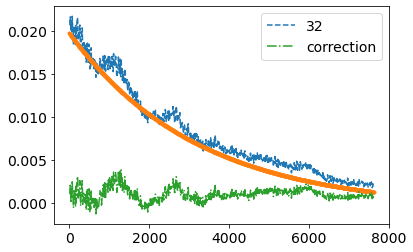

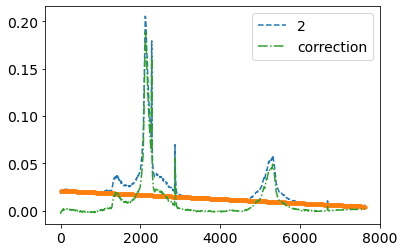

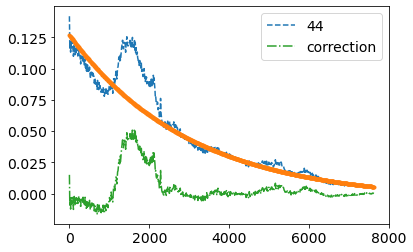

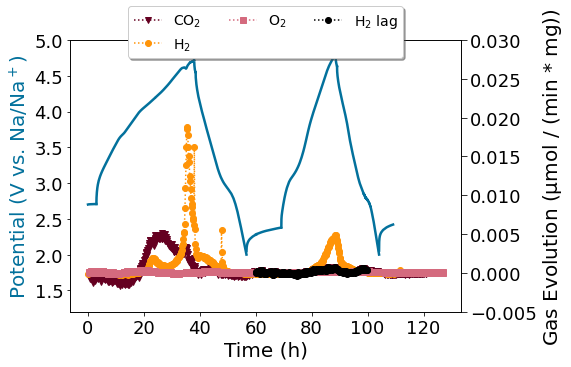

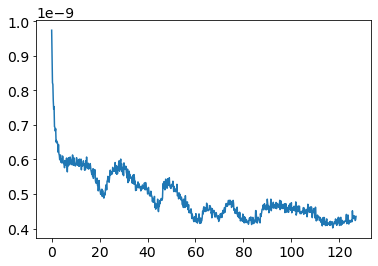

In [136]:
LMO_folder = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2022/220906_EAK-WY_LMO_2cycles/')
LMO_cy1 = read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2022/220906_EAK-WY_LMO_2cycles/220906_EAK-WY_LMO_cycle1_2022-09-06_18.59_07_ch1.txt')
end_time1 = LMO_cy1['time/min'].iloc[-1]*60

LMO_cy2 = read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2022/220906_EAK-WY_LMO_2cycles/220906_EAK-WY_LMO_cycle2_2022-09-09_07.18_13_ch1.txt')
LMO_cy2['time/min'] += end_time1/60

both_cycles = pd.concat([LMO_cy1,LMO_cy2])
for i in range(5,len(LMO_folder)):
    LMO_folder[i]['time/s'] = LMO_folder[i]['time/s']+ end_time1

plot_naion_dems(LMO_folder, both_cycles, 1, 2.331)


#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/2022/220906_EAK-WY_LMO_2cycles/220906_EAK-WY_LMO_2cycles.png', transparent= True, dpi=800, bbox_inches='tight')


plt.figure()
plt.plot(both_cycles['time/min']/60, both_cycles['36'])


/Users/kedzie/miniconda3/envs/py3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


o2: 0.36820015857366667  h2: 0.2089378045181316 co2:  1.5885234812840174 73.35049923936101%
lag time =  402.01586999999995
umoles O2: 0.36820015857366667
e per mol: 65.39500276640915


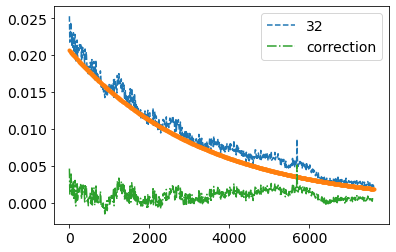

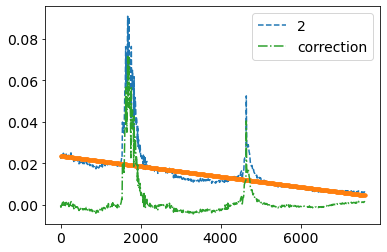

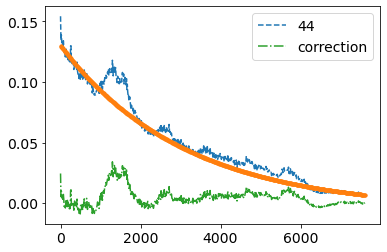

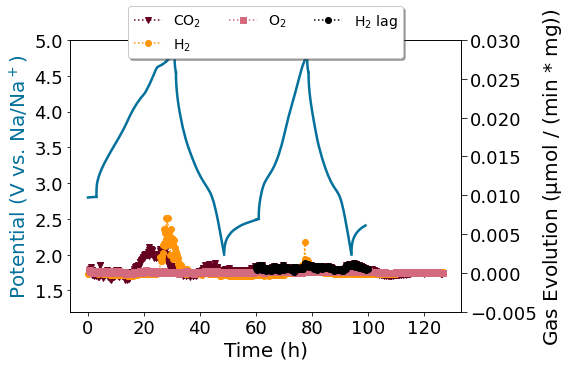

In [133]:

LMO65_folder = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2022/220906_EAK-WY_65LMO_35LMO_2cycles/')
LMO65_cy1 = read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2022/220906_EAK-WY_65LMO_35LMO_2cycles/220906_EAK-WY_65LMO_35LMO_2cycles_2022-09-06_18.59_07_ch2.txt')
end_time2 = LMO65_cy1['time/min'].iloc[-1]*60


LMO65_cy2 = read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2022/220906_EAK-WY_65LMO_35LMO_2cycles/220906_EAK-WY_65LMO_35LMO_cycle2_2022-09-09_07.18_13_ch2.txt')
LMO65_cy2['time/min'] += end_time2/60

both_cycles2 = pd.concat([LMO65_cy1,LMO65_cy2])
#both_cycles2.drop([0,1,2,3,4,5,6,7,8,9,10])


for i in range(5,len(LMO65_folder)):
    LMO65_folder[i]['time/s'] = LMO65_folder[i]['time/s']+ end_time2

plot_naion_dems(LMO65_folder, both_cycles2, 1, 1.771)

#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/2022/220906_EAK-WY_65LMO_35LMO_2cycles/220906_EAK-WY_65LMO_35LMO_2cycles.png', transparent= True, dpi=800, bbox_inches='tight')



